In [1]:
import os
from six.moves import urllib
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
#import seaborn as sns

from IPython.core.pylabtools import figsize
#figsize(11, 9)
import time
import tensorflow as tf
import tensorflow_probability as tfp

import sys
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn/models')

from models.multilevel_layers import MultilevelDense

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
import datetime


tfd = tfp.distributions

In [2]:
%load_ext tensorboard

# Fake data

In [4]:
np.random.seed(7)

#### diff data

In [5]:
np.random.seed(8)

n1=20+20
x1 = np.random.randn(n1)
gid1 = (np.zeros(n1)).astype(np.int32)
y1 = 2*x1 + np.random.randn(n1)

n2=10+10
x2 = np.random.randn(n2)
gid2 = (np.zeros(n2) + 1).astype(np.int32)
y2 = -1.5*x2 + 2 +  np.random.randn(n2)

n3=5+5
x3 = np.random.randn(n3)
gid3 = (np.zeros(n3) + 2).astype(np.int32)
y3 = 1*x3 + 2 + np.random.randn(n3)

#### same data

In [536]:
def data_generator(x_tf, gid_tf):
    x_tf = tf.cast(tf.convert_to_tensor(x_tf), tf.float32)
    num_groups = tf.cast(tf.convert_to_tensor(max(gid_tf) + 1), tf.int32)
    """Creates a joint distribution for the varying slope model."""
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=1., scale=0.1, name='w_z_0'),          # z_0 ~ N(0, v^-1=1e5)
        
        tfd.Independent(
            tfd.HalfCauchy(loc=tf.ones([num_groups])*0.1, scale=0.01, name='w_lambda_k'),
            reinterpreted_batch_ndims=1),

        lambda w_lambda_k, w_z_0: tfd.MultivariateNormalDiag( # z_k ~ MVN(z_0, lambda_k)
            loc=w_z_0[...,tf.newaxis],
            scale_diag=w_lambda_k,
            name='w_z_k'),

        tfd.Normal(loc=1., scale=1., name='b_z_0'),          # z_0 ~ N(0, v^-1=1e5)
        tfd.Independent(
            tfd.HalfCauchy(loc=tf.ones([num_groups])*0.1, scale=0.01, name='b_lambda_k'), 
            reinterpreted_batch_ndims=1),
        
        lambda b_lambda_k, b_z_0: tfd.MultivariateNormalDiag( # z_k ~ MVN(z_0, lambda_k)
            loc=b_z_0[...,tf.newaxis],
            scale_diag=b_lambda_k,
            name='b_z_k'),
        
        #tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
        # set sigma_y to 1
        
        # b_lambda_k, b_z_0 are unused
        lambda b_z_k, b_lambda_k, b_z_0, w_z_k: tfd.MultivariateNormalDiag(  # y
            loc=affine(x_tf, tf.gather(w_z_k, gid_tf, axis=-1),
                       tf.gather(b_z_k, gid_tf, axis=-1)),
            scale_identity_multiplier=0.1,
            name='y')
   ])

In [537]:
ng=10
avg_samp = 70
np.random.seed(35)
xi, gi = np.random.randn(ng*avg_samp), np.random.choice(ng, size=[ng*avg_samp])

In [538]:
collections.Counter(gi)

Counter({9: 71, 8: 75, 3: 53, 2: 79, 1: 77, 6: 57, 5: 53, 0: 74, 7: 79, 4: 82})

In [539]:
gen_process = data_generator(xi, gi)

In [540]:
tf.random.set_seed(4)
gen = gen_process.sample(seed=7)

In [541]:
yi=gen[-1].numpy()
gen[:-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.9806732>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.13854052, 0.10953002, 0.11357766, 0.1066361 , 0.10249147,
        0.18223721, 0.37597683, 0.10358339, 0.10822483, 0.10327221],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.87193704, 0.9819067 , 1.1165752 , 0.9587579 , 0.9186158 ,
        0.757276  , 1.2185165 , 0.985904  , 0.82969713, 1.2186017 ],
       dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.06006956>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.10316875, 0.13092539, 0.11375074, 0.10715556, 0.17309141,
        0.11350709, 0.13402292, 0.14331701, 0.12857775, 0.11069977],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([-0.01686365, -0.06156071, -0.04285464,  0.03493781, -0.08122241,
        -0.25375843, -0.17712763, -0.3588028 , -0.07939266, -0.16003355],
       dtype=float32)>]

In [542]:
xi[4], yi[4], gi[4]

(-1.4215978347675524, -1.6010562, 1)

In [543]:
x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
    xi, yi, gi, stratify=gi, random_state=9, test_size=0.8)
tts = [x_train, x_test, y_train, y_test, gid_train, gid_test]

In [544]:
collections.Counter(gid_train)

Counter({5: 11, 2: 16, 4: 16, 8: 15, 1: 15, 7: 16, 0: 15, 6: 11, 3: 11, 9: 14})

In [545]:
get_segments = lambda data, gid, idx: data[np.where(gid == idx)[0]]


In [546]:
get_segments(x_train, gid_train, 3)

array([ 0.70411785,  0.67760593, -1.04946697,  1.8818798 , -0.19624327,
       -1.13719175, -0.76602601, -0.55943181,  1.80568598,  1.54885466,
        0.95345075])

In [547]:
get_segments(y_train, gid_train, 3)

array([ 0.6081427 ,  0.61756223, -1.0405846 ,  1.9073989 , -0.07663824,
       -0.9750082 , -0.6933419 , -0.53208274,  1.6782302 ,  1.5992402 ,
        1.1520898 ], dtype=float32)

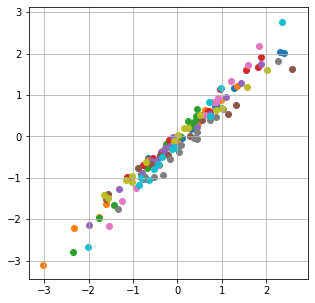

In [548]:
plt.figure(figsize=(5,5))
for i in range(ng):
    plt.scatter(get_segments(x_train, gid_train, i), get_segments(y_train, gid_train, i))
plt.grid()

In [549]:
def regression(x_train, x_test, y_train, y_test):
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1),
                  loss='mse', metrics=['mse'])
    
    print(x_train.shape, y_train.shape)
    model.fit(x_train, y_train, batch_size=len(x), epochs=200, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    m, b = model.get_weights()
    m, b = round(m[0,0], 3), round(b[0], 3)
    print(m,b)
    
    return model, (m, b)

In [550]:
model, (m, b) = regression(*tts[:4])

(140, 1) (140,)
MSE 0.044
R2 0.959
0.984 -0.125


In [551]:
xs = np.linspace(-5, 5, 5)
ys = m*xs + b

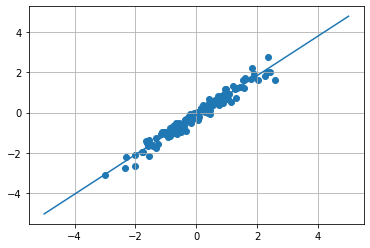

In [552]:
plt.scatter(x_train,y_train)
plt.plot(xs,ys)
plt.grid(True)

In [553]:
get_segments(x_test, gid_test, 1)

array([-1.54402522,  1.83175301, -1.88032655,  2.24399112,  1.13908391,
        0.7540383 , -1.49413604,  0.97401808,  1.75231088,  1.60909264,
        0.1214234 ,  0.02099369, -0.37503666,  0.11478646, -1.36798891,
       -0.37800805,  0.25288418,  0.12995163,  0.59617625,  0.28869885,
       -0.6797101 ,  0.5922021 , -1.42159783, -0.27211374,  0.75441052,
       -0.60939776, -0.49167264,  1.30206019,  1.04234407, -0.7761748 ,
        0.44898608,  1.54588403, -0.05724552, -0.21646871, -0.2039299 ,
       -0.18688614,  0.49596292, -0.68972335,  0.14040026, -1.47404051,
       -0.35878759, -0.33704529,  0.45734696,  0.09863997, -0.1430368 ,
        0.0360235 ,  0.02066283, -0.80200928,  1.2665646 ,  0.65272154,
       -0.81679494, -1.0477108 , -1.20582434,  1.53958652,  0.04934099,
        0.89005539,  1.16630399,  1.14886176, -1.78632375, -0.08028061,
        0.67171219, -1.7595687 ])

In [554]:
models = []
coefs = []
for i in range(ng):
    model, (m,b) = regression(
        get_segments(x_train, gid_train, i), 
       
        get_segments(x_test, gid_test, i),
         get_segments(y_train, gid_train, i),
        get_segments(y_test, gid_test, i))
    models.append(model)
    coefs.append([m,b])

(15, 1) (15,)
MSE 0.013
R2 0.978
0.888 -0.048
(15, 1) (15,)
MSE 0.009
R2 0.991
0.986 -0.054
(16, 1) (16,)
MSE 0.019
R2 0.989
1.16 -0.01
(11, 1) (11,)
MSE 0.01
R2 0.991
0.966 0.047
(16, 1) (16,)
MSE 0.012
R2 0.986
0.963 -0.092
(11, 1) (11,)
MSE 0.012
R2 0.981
0.736 -0.218
(11, 1) (11,)
MSE 0.009
R2 0.994
1.217 -0.162
(16, 1) (16,)
MSE 0.01
R2 0.989
0.986 -0.387
(15, 1) (15,)
MSE 0.018
R2 0.972
0.85 -0.058
(14, 1) (14,)
MSE 0.009
R2 0.994
1.233 -0.143


In [555]:
xs = np.linspace(-3, 3, 5)

In [556]:
models[0].predict(xs)

array([[-2.7114677 ],
       [-1.3798594 ],
       [-0.04825114],
       [ 1.2833571 ],
       [ 2.6149654 ]], dtype=float32)

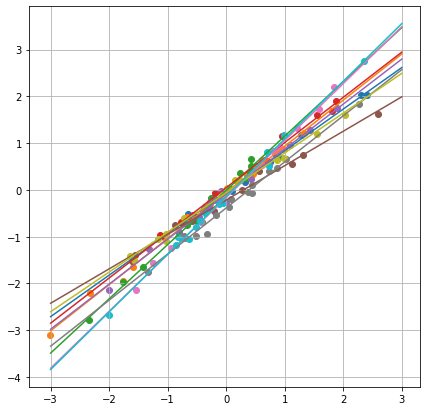

In [557]:
plt.figure(figsize=(7,7))
for i in range(ng):
    model=models[i]
    ys = np.squeeze(model.predict(xs))
    plt.scatter(get_segments(x_train, gid_train, i), get_segments(y_train, gid_train, i))
    plt.plot(xs,ys)
plt.grid()

In [558]:
models = []
coefs = []
for i in range(ng):
    model, (m,b) = regression(
        get_segments(xi, gi, i), 
       
        get_segments(xi, gi, i),
         get_segments(yi, gi, i),
        get_segments(yi, gi, i))
    models.append(model)
    coefs.append([m,b])

(74, 1) (74,)
MSE 0.009
R2 0.986
0.866 -0.004
(77, 1) (77,)
MSE 0.008
R2 0.993
0.981 -0.058
(79, 1) (79,)
MSE 0.01
R2 0.994
1.106 -0.063
(53, 1) (53,)
MSE 0.01
R2 0.992
0.96 0.032
(82, 1) (82,)
MSE 0.009
R2 0.989
0.922 -0.082
(53, 1) (53,)
MSE 0.009
R2 0.986
0.741 -0.259
(57, 1) (57,)
MSE 0.008
R2 0.995
1.228 -0.179
(79, 1) (79,)
MSE 0.008
R2 0.991
0.987 -0.352
(75, 1) (75,)
MSE 0.015
R2 0.978
0.827 -0.075
(71, 1) (71,)
MSE 0.009
R2 0.994
1.221 -0.156


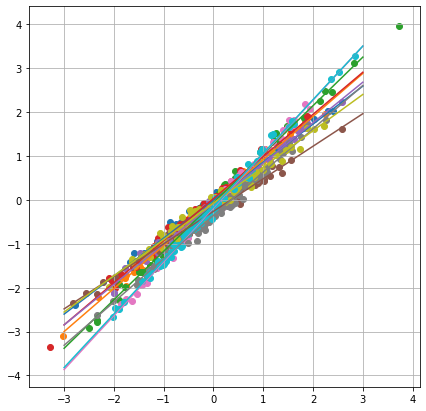

In [559]:
plt.figure(figsize=(7,7))
for i in range(ng):
    model=models[i]
    ys = np.squeeze(model.predict(xs))
    plt.scatter(get_segments(xi, gi, i), get_segments(yi, gi, i))
    plt.plot(xs,ys)
plt.grid()

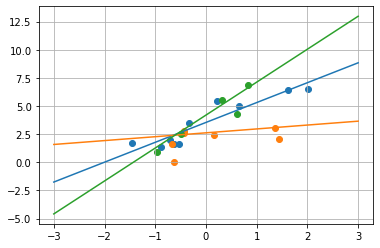

In [212]:
plt.scatter(get_segments(x_train, gid_train, 0), get_segments(y_train, gid_train, 0))
plt.scatter(get_segments(x_train, gid_train, 1), get_segments(y_train, gid_train, 1))
plt.scatter(get_segments(x_train, gid_train, 2), get_segments(y_train, gid_train, 2))
plt.plot(xs,ys1)
plt.plot(xs,ys2)
plt.plot(xs,ys3)
plt.grid(True)

In [3]:
np.random.seed(16)

n1=70
x1 = np.random.randn(n1)
gid1 = (np.zeros(n1)).astype(np.int32)
y1 = 1.5*x1 + np.random.randn(n1)*1 + 3.5

n2=50
x2 = np.random.randn(n2)
gid2 = (np.zeros(n2) + 1).astype(np.int32)
y2 = 0.8*x2 +  np.random.randn(n2)*1 + 2.25

n3=30
x3 = np.random.randn(n3)
gid3 = (np.zeros(n3) + 2).astype(np.int32)
y3 = 2.5*x3 + np.random.randn(n3)*1 + 4.3

(-4, 4.5)

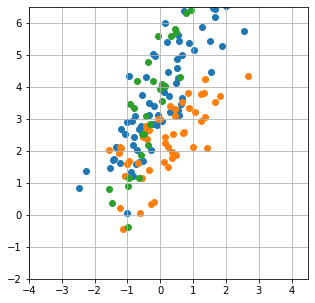

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)
plt.grid(True)
plt.ylim([-2,6.5])
plt.xlim([-4,4.5])

In [5]:
x = np.concatenate([x1,x2,x3]).astype(np.float32)
gid = np.concatenate([gid1,gid2,gid3]).astype(np.int32)
y = np.concatenate([y1,y2,y3]).astype(np.float32)

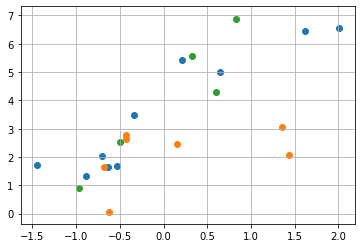

In [6]:
x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.85)

get_segments = lambda data, gid, idx: data[np.where(gid == idx)[0]]
plt.scatter(get_segments(x_train, gid_train, 0), get_segments(y_train, gid_train, 0))
plt.scatter(get_segments(x_train, gid_train, 1), get_segments(y_train, gid_train, 1))
plt.scatter(get_segments(x_train, gid_train, 2), get_segments(y_train, gid_train, 2))
plt.grid()

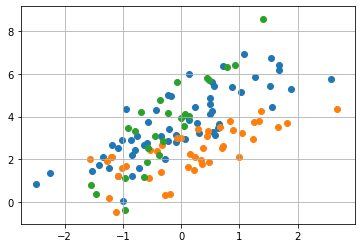

In [8]:
plt.scatter(get_segments(x_test, gid_test, 0), get_segments(y_test, gid_test, 0))
plt.scatter(get_segments(x_test, gid_test, 1), get_segments(y_test, gid_test, 1))
plt.scatter(get_segments(x_test, gid_test, 2), get_segments(y_test, gid_test, 2))
plt.grid()

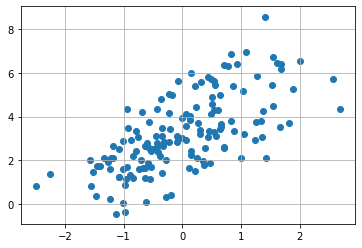

In [204]:
plt.scatter(x,y)
plt.grid(True)

In [7]:
x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
    x, y, gid, stratify=gid, random_state=9, test_size=0.85)

In [177]:
def regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.85)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=200, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    m, b = model.get_weights()
    m, b = round(m[0,0], 3), round(b[0], 3)
    print(m,b)
    
    return model, (m, b)

In [178]:
model, (m, b) = regression(x, y, gid)

MSE 1.009
R2 0.692
0.486 1.102


In [182]:
xs = np.linspace(-10, 10, 5)
ys = m*xs + b

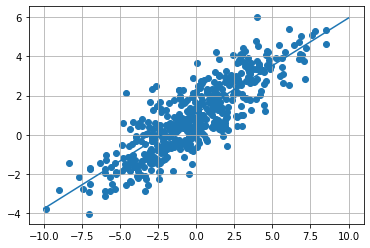

In [183]:
plt.scatter(x,y)
plt.plot(xs,ys)
plt.grid(True)

In [210]:
model1, (m1, b1) = regression(x1, y1, gid1)
model2, (m2, b2) = regression(x2, y2, gid2)
model3, (m3, b3) = regression(x3, y3, gid3)

MSE 1.132
R2 0.566
1.766 3.545
MSE 1.04
R2 0.211
0.345 2.622
MSE 0.813
R2 0.811
2.927 4.198


In [211]:
xs = np.linspace(-3, 3, 5)
ys1 = m1*xs + b1
ys2 = m2*xs + b2
ys3 = m3*xs + b3

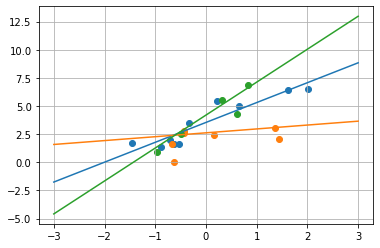

In [212]:
plt.scatter(get_segments(x_train, gid_train, 0), get_segments(y_train, gid_train, 0))
plt.scatter(get_segments(x_train, gid_train, 1), get_segments(y_train, gid_train, 1))
plt.scatter(get_segments(x_train, gid_train, 2), get_segments(y_train, gid_train, 2))
plt.plot(xs,ys1)
plt.plot(xs,ys2)
plt.plot(xs,ys3)
plt.grid(True)

### Dense variational

In [212]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [213]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=tf.nn.softplus(t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


In [214]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [215]:
def bayesian_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    kernel, prior = model.get_weights()
    
    
    #m, b = round(m[0,0], 3), round(b[0], 3)
    print(kernel, prior)
    
    return model, (kernel, prior)

In [216]:
model, (kernel, prior) = bayesian_regression(x, y, gid)

MSE 1.1
R2 0.655
[ 1.6569409   0.00633746 -3.1081867  -3.0018184 ] [1.6392776  0.04294498]


In [217]:
def get_pred_matrix(xs, kernel, prior):
    m_mu, b_mu, m_sig, b_sig = kernel
    m_sig, b_sig = tf.nn.softplus([ m_sig, b_sig])
    
    m_range = np.linspace(-2*m_sig, 2*m_sig, 10)
    b_range = np.linspace(-2*b_sig, 2*b_sig, 10)
    
    pred_matrix = np.outer(m_mu+m_range[::-1], xs) + np.expand_dims(b_mu + b_range[::-1],axis=1)
    return pred_matrix

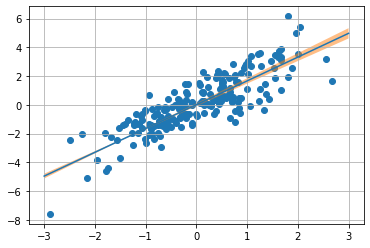

In [218]:
xs = np.linspace(-3, 3, 5)
pred_matrix = get_pred_matrix(xs, kernel, prior)

plt.scatter(x,y)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
plt.grid(True)

In [219]:
pred_matrix

array([[-5.12975774e+00, -2.51320900e+00,  1.03339739e-01,
         2.71988848e+00,  5.33643722e+00],
       [-5.09303054e+00, -2.50562343e+00,  8.17836775e-02,
         2.66919079e+00,  5.25659790e+00],
       [-5.05630334e+00, -2.49803786e+00,  6.02276163e-02,
         2.61849310e+00,  5.17675858e+00],
       [-5.01957615e+00, -2.49045230e+00,  3.86715552e-02,
         2.56779541e+00,  5.09691926e+00],
       [-4.98284895e+00, -2.48286673e+00,  1.71154940e-02,
         2.51709771e+00,  5.01707993e+00],
       [-4.94612175e+00, -2.47528116e+00, -4.44056720e-03,
         2.46640002e+00,  4.93724061e+00],
       [-4.90939455e+00, -2.46769559e+00, -2.59966284e-02,
         2.41570233e+00,  4.85740129e+00],
       [-4.87266735e+00, -2.46011002e+00, -4.75526895e-02,
         2.36500464e+00,  4.77756197e+00],
       [-4.83594015e+00, -2.45252445e+00, -6.91087507e-02,
         2.31430695e+00,  4.69772265e+00],
       [-4.79921296e+00, -2.44493888e+00, -9.06648119e-02,
         2.26360926e+00

#### by group

In [220]:
model1, (kernel1, prior1) = bayesian_regression(x1, y1, gid1)
model2, (kernel2, prior2) = bayesian_regression(x2, y2, gid2)
model3, (kernel3, prior3) = bayesian_regression(x3, y3, gid3)

MSE 0.469
R2 0.835
[ 1.4063457  0.5982234 -2.4869473 -2.5226219] [1.4634345 0.424736 ]
MSE 0.405
R2 0.479
[ 0.9180655 -0.3543587 -2.3485358 -2.4177883] [ 0.9613714  -0.43309557]
MSE 0.47
R2 0.927
[ 2.548387   0.402381  -2.3155909 -2.428192 ] [2.5969317  0.27303842]


In [221]:
xs = np.linspace(-2, 2, 5)
ys1 = m1*xs + b1
ys2 = m2*xs + b2
ys3 = m3*xs + b3

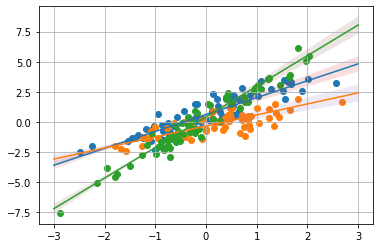

In [222]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

xs = np.linspace(-3, 3, 10)

pred_matrix = get_pred_matrix(xs, kernel1, prior1)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

pred_matrix = get_pred_matrix(xs, kernel2, prior2)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

pred_matrix = get_pred_matrix(xs, kernel3, prior3)
plt.plot(xs,np.mean(pred_matrix, axis=0))
plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.15)

plt.grid(True)

### one hot / deep 

In [223]:
def deep_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, shuffle=True, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4, activation='sigmoid'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    return model

In [224]:
xp = np.concatenate([np.expand_dims(x,axis=1), to_categorical(gid)], axis=1)
model = deep_regression(xp, y, gid)

MSE 0.488
R2 0.847


In [225]:
xs = np.linspace(-3, 3, 5)
xs = np.expand_dims(xs, 1)
xs = np.concatenate([xs, np.tile(np.array([0,0,0]), 5).reshape((5,3))], axis=1)
ys = model.predict(xs)

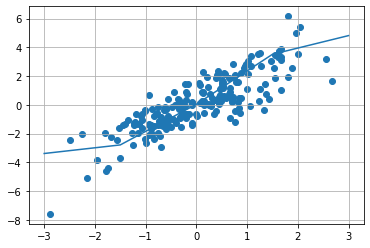

In [229]:
plt.scatter(x,y)
plt.plot(np.linspace(-3, 3, 5),ys)
plt.grid(True)

In [230]:
xs1 = np.linspace(-3, 3, 5)
xs1 = np.expand_dims(xs1, 1)
xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
ys1 = model.predict(xs1)

xs2 = np.linspace(-3, 3, 5)
xs2 = np.expand_dims(xs2, 1)
xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
ys2 = model.predict(xs2)

xs3 = np.linspace(-3, 3, 5)
xs3 = np.expand_dims(xs3, 1)
xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
ys3 = model.predict(xs3)

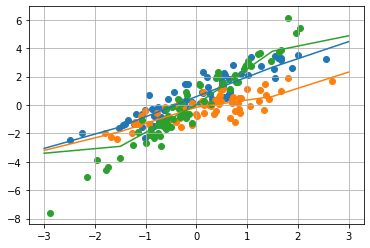

In [231]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

plt.plot(np.linspace(-3, 3, 5),ys1)
plt.plot(np.linspace(-3, 3, 5),ys2)
plt.plot(np.linspace(-3, 3, 5),ys3)
plt.grid(True)

### one hot deep bayesian regression

In [236]:
def deep_bayesian_regression(x, y, gid):
    
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
    
    model = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(4, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],
                                    activation='sigmoid'),
        tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit(x_train, y_train, batch_size=len(x), epochs=100, verbose=False)
    
    print('MSE', round(mean_squared_error(y_test, model.predict(x_test)), 3))
    print('R2', round(r2_score(y_test, model.predict(x_test)), 3))
    
    return model

In [237]:
xp = np.concatenate([np.expand_dims(x,axis=1), to_categorical(gid)], axis=1)
model = deep_bayesian_regression(xp, y, gid)

MSE 0.774
R2 0.797


In [238]:
x_plot = np.linspace(-3, 3, 5)
xs = np.expand_dims(x_plot, 1)
xs = np.concatenate([xs, np.tile(np.array([0,0,0]), 5).reshape((5,3))], axis=1)
ys = model.predict(xs)

pred_matrix = np.concatenate([model.predict(xs) for _ in range(100)], axis=1).T

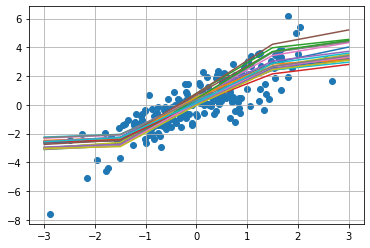

In [239]:

#pred_matrix = get_one_hot_pred_matrix(xs, kernel, prior)

plt.scatter(x,y)
#plt.plot(xs,np.mean(pred_matrix, axis=0))
#plt.fill_between(xs, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
for _ in range(20):
    plt.plot(x_plot, model.predict(xs))
plt.grid(True)

In [240]:
xs1 = np.linspace(-3, 3, 5)
xs1 = np.expand_dims(xs1, 1)
xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
pred_matrix1 = np.concatenate([model.predict(xs1) for _ in range(100)], axis=1).T

xs2 = np.linspace(-3, 3, 5)
xs2 = np.expand_dims(xs2, 1)
xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
pred_matrix2 = np.concatenate([model.predict(xs2) for _ in range(100)], axis=1).T

xs3 = np.linspace(-3, 3, 5)
xs3 = np.expand_dims(xs3, 1)
xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
pred_matrix3 = np.concatenate([model.predict(xs3) for _ in range(100)], axis=1).T

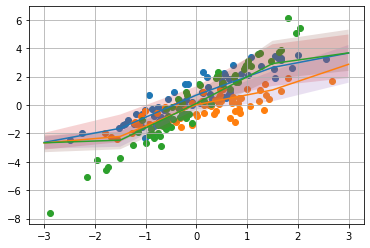

In [241]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)

# plt.plot(np.linspace(-1, 1, 5),ys1)
# plt.plot(np.linspace(-1, 1, 5),ys2)
# plt.plot(np.linspace(-1, 1, 5),ys3)

xs1 = np.linspace(-3, 3, 5)
xs2 = np.linspace(-3, 3, 5)
xs3 = np.linspace(-3, 3, 5)

plt.plot(xs1,np.mean(pred_matrix1, axis=0))
plt.fill_between(xs1, np.max(pred_matrix1, axis=0),  np.min(pred_matrix1, axis=0), alpha=0.2)

plt.plot(xs2,np.mean(pred_matrix2, axis=0))
plt.fill_between(xs2, np.max(pred_matrix2, axis=0),  np.min(pred_matrix2, axis=0), alpha=0.2)

plt.plot(xs3,np.mean(pred_matrix3, axis=0))
plt.fill_between(xs3, np.max(pred_matrix3, axis=0),  np.min(pred_matrix3, axis=0), alpha=0.2)
plt.grid(True)

### Hierarchical

In [481]:
def prep_data(x_train, x_test, y_train, y_test, gid_train, gid_test):

    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    
    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)
        
    if len(y_train.shape) == 1:
        y_train = np.expand_dims(y_train, axis=1)
        y_test = np.expand_dims(y_test, axis=1)

    #x_train = np.concatenate([x_train,np.zeros((len(x_train), 1)).astype(np.float32)], axis=1)
    #x_test = np.concatenate([x_test,np.zeros((len(x_train), 1)).astype(np.float32)], axis=1)
    
    train_data = [x_train, gid_train, y_train]
    test_data = [x_test, gid_test, y_test]
    
    return train_data, test_data

In [42]:


"""def multilevel_regression(x, y, gid):
    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(
        x, y, gid, stratify=gid, random_state=9, test_size=0.5)

    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)


    if len(x_train.shape) == 1:
        x_train = np.expand_dims(x_train, axis=1)
        x_test = np.expand_dims(x_test, axis=1)

    x_train = np.concatenate([x_train,x_train], axis=1)
    x_test = np.concatenate([x_test,x_test], axis=1)
    
#     model = tf.keras.models.Sequential([
#         #tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],
#         #                            activation='sigmoid'),
#         #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])
#         self.ml_dense = MultilevelDense(62, num_groups=self.num_groups[0], activation='softmax')
        
#     ])
    print(x_train.dtype, y_train.dtype, gid_train.dtype)
    
    x_input = Input(shape=(2,), dtype=tf.float32)
    gid_input = Input(shape=(1,), dtype=tf.int32)
    ml_dense = MultilevelDense(1, num_groups=3, multilevel_weights=True, multilevel_bias=True)
    #print(ml_dense, ml_dense.get_weights())
    
    out = ml_dense([x_input, gid_input])
    model = Model(inputs=[x_input, gid_input], outputs=[out])
    
    #print('before', x_train.shape, gid_train.shape)
    model([x_train, gid_train])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
                  loss='mse', metrics=['mse'])
    
    model.fit([x_train, gid_train], y_train, batch_size=len(x), epochs=1000, verbose=False)
    
    #print(model([x_test, gid_test]).shape)
    #preds = model([x_test, gid_test])
    #print(preds.shape,type(preds),  y_test.shape)
    #print(preds, y_test)
    #print('MSE', round(mean_squared_error(y_test, preds), 3))
    #print('R2', round(r2_score(y_test, preds), 3))
    
    return model"""

"def multilevel_regression(x, y, gid):\n    x_train, x_test, y_train, y_test, gid_train, gid_test = train_test_split(\n        x, y, gid, stratify=gid, random_state=9, test_size=0.5)\n\n    x_train = x_train.astype(np.float32)\n    x_test = x_test.astype(np.float32)\n\n\n    if len(x_train.shape) == 1:\n        x_train = np.expand_dims(x_train, axis=1)\n        x_test = np.expand_dims(x_test, axis=1)\n\n    x_train = np.concatenate([x_train,x_train], axis=1)\n    x_test = np.concatenate([x_test,x_test], axis=1)\n    \n#     model = tf.keras.models.Sequential([\n#         #tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0],\n#         #                            activation='sigmoid'),\n#         #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0])\n#         self.ml_dense = MultilevelDense(62, num_groups=self.num_groups[0], activation='softmax')\n        \n#     ])\n    print(x_train.dtype, y_train.dtyp

In [480]:
import ipdb

In [482]:
train_data, test_data = prep_data(*tts)

In [374]:
loc1 = 0.02

In [477]:
tf.reduce_sum(tfd.Normal(
    loc=loc1, 
    scale=tf.nn.softplus(np.log(np.expm1(1.)) + 4)
).kl_divergence(tfd.Normal(
    tf.cast(0., tf.float64), 
    tf.cast(10, tf.float64))))

<tf.Tensor: id=605021, shape=(), dtype=float64, numpy=0.3906365048283221>

In [376]:
2.97*5

14.850000000000001

In [315]:
(tf.math.log(10/tf.nn.softplus(np.log(np.expm1(1.)) - 8))
            + (tf.nn.softplus(np.log(np.expm1(1.)) - 8)**2 + (loc1-0)**2)/(2*10**2)
            - 0.5)

<tf.Tensor: id=595465, shape=(), dtype=float64, numpy=9.261550380513436>

### MC log prob term

In [645]:
np.random.seed(1)

zk = (
    tfd.Normal(
        loc = np.random.normal(0, 0.05, (50,)),
        scale = tf.nn.softplus(np.log(np.expm1(1.)) - 8))
    )

z0 = (
    tfd.Normal(
        loc = np.random.normal(0, 0.05,),
        scale = tf.nn.softplus(np.log(np.expm1(1.)) - 8))
    .sample())

In [558]:
zk.sample()

<tf.Tensor: id=606486, shape=(50,), dtype=float64, numpy=
array([ 0.08222977, -0.03052151, -0.02598753, -0.05423937,  0.04349178,
       -0.11508022,  0.08654783, -0.0386095 ,  0.01494463, -0.01286191,
        0.07309356, -0.10352607, -0.015766  , -0.01988891,  0.05613174,
       -0.05433681, -0.00842792, -0.04419903,  0.00226476,  0.02869655,
       -0.0550177 ,  0.05800075,  0.04549488,  0.02525133,  0.0445773 ,
       -0.03511447, -0.00550649, -0.04562079, -0.01276642,  0.02686526,
       -0.03515018, -0.01931177, -0.03400299, -0.04212197, -0.03257997,
       -0.00065003, -0.0547865 ,  0.01143661,  0.0832361 ,  0.03664976,
       -0.00904316, -0.04409424, -0.03654018,  0.08476398,  0.00327269,
       -0.0320988 ,  0.00993086,  0.10431337,  0.0058528 ,  0.03094901])>

In [527]:
tf.reduce_mean(tf.reduce_sum((zk.sample() - z0)**2, axis=[-1]))

<tf.Tensor: id=606079, shape=(), dtype=float64, numpy=56.083708125037994>

In [646]:
tau_k = (
    tfd.Normal(
        loc = np.random.normal(2, 0.05, (50,)),
        scale = tf.nn.softplus(np.log(np.expm1(1.)) - 8))
    .sample()
    ** 2)

In [647]:
tau_k.numpy().round(1)

array([3.9, 3.8, 3.9, 4. , 4.1, 4.2, 4.2, 4.1, 4.2, 3.9, 4.3, 4.1, 3.9,
       4.1, 4. , 4.2, 4.3, 4.5, 3.7, 3.7, 3.9, 4. , 4.2, 4.1, 3.6, 3.9,
       4.2, 4. , 4.2, 4. , 4. , 4. , 4.1, 4. , 4. , 3.9, 4.1, 4. , 4.2,
       4.2, 4. , 3.9, 3.9, 4.1, 4. , 3.9, 4. , 3.9, 4.1, 3.9])

In [648]:
#base_normal = tfd.Normal(loc = z0, scale = tau_k)
base_normal = tfd.Normal(loc = z0, scale = tau_k)

In [649]:
-1 * tf.reduce_sum(base_normal.log_prob(zk.sample()))

<tf.Tensor: id=608557, shape=(), dtype=float64, numpy=115.57126500886051>

In [635]:
tf.reduce_sum(zk.kl_divergence(base_normal))

<tf.Tensor: id=607941, shape=(), dtype=float64, numpy=417.72979526532157>

In [826]:
from models.multilevel_layers import MultilevelDense, MyDense, TFPMultilevelDense, MyMultilevelDense, TFPDense

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [838]:


class MultilevelRegression(tf.keras.models.Model):
    
    def __init__(self, optimizer, loss_fn, train_size, group_train_sizes):
        super(MultilevelRegression, self).__init__()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_size = train_size
        self.group_train_sizes = group_train_sizes
        
        group_kl_weights = 1. / np.array(group_train_sizes).astype(np.float32)
        
        #self.ml_dense = MultilevelDense(1, num_groups=3, multilevel_weights=True, multilevel_bias=True)
        #self.ml_dense = TFPDense(1, num_groups=3, multilevel_weights=False, multilevel_bias=False)
        #self.ml_dense4 = MyMultilevelDense(4, num_groups=3, multilevel_weights=True, multilevel_bias=True
        #                                , activation='sigmoid'
        #                                 )
        self.ml_dense = MyMultilevelDense(1, num_groups=num_groups, multilevel_weights=True, multilevel_bias=True, group_kl_weights=group_kl_weights)
        #self.ml_dense = TFPMultilevelDense(1, num_groups=3, multilevel_weights=True, multilevel_bias=True, kl_use_exact=True)
        #self.ml_dense = MyDense(1)
        #self.dense = tf.keras.layers.Dense(1)
        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = '../experiments/linear/tensorboard/' + current_time
        self.train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        
        
        
    def call(self, inputs):
        x, gid = inputs
        #x = self.ml_dense4([x, gid])
        out = self.ml_dense([x,gid])
        #out = self.dense(x)
        #print(out)
        return out
        
    def create_batch_generator(self, data, batch_size):
        generator = tf.data.Dataset.from_tensor_slices(tuple(data))
        generator = generator.batch(batch_size)
        return generator

    def train(self, train_data, test_data, batch_size, num_epochs, eval_every=1, print_freq=10):

        # TODO: find less hacky way to build model, get summary
        #inputs, _ = train_data[:-1], train_data[-1]
        #inputs = [x[:5] for x in inputs]
        #_ = self(inputs)
        ## Try to print summary of param counts, won't work for some models
        #try:
        #    self.summary()
        #except:
        #    print('Configuration not amenable to `summary`.')

        # Stateful Keras object for keeping track of mean loss
        train_loss = tf.keras.metrics.Mean('train_loss')
        mean_kl_loss = tf.keras.metrics.Mean('kl_loss')

        last_time = time.time()
        #for epoch in range(1, num_epochs+1):
        #    print('--- Epoch {} ---'.format(epoch))

        for epoch in range(1, num_epochs+1):
            train_generator = self.create_batch_generator(train_data, batch_size)

            for step, batch in enumerate(train_generator):
                num_batches = np.ceil(len(train_data[0])/batch_size)
                global_step = (epoch-1)*num_batches + step
                loss, kl_loss = self.train_step(batch, global_step, num_batches, epoch, num_epochs)
                train_loss(loss)
                mean_kl_loss(kl_loss)

                # Print out train loss every 1/print_freq thru train set
                #num_batches = np.ceil(len(train_data[0])/batch_size)
                #if (step+1) % np.ceil(num_batches/print_freq) == 0 or (step+1) == num_batches:
                if (epoch+1) % print_freq == 0:
                    print('Step {} - train loss: {:.5f}, time elapsed: {:d}s'.format(
                        step+1, train_loss.result().numpy(),
                        round(time.time()-last_time)))

                    last_time = time.time()


                    with self.train_summary_writer.as_default():
                        tf.summary.scalar('total_loss', train_loss.result(), step=global_step)
                        tf.summary.scalar('kl_loss', mean_kl_loss.result(), step=global_step)
                        tf_summ_weights = lambda name, weight: tf.summary.scalar(name, tf.squeeze(weight), step=global_step)
                        tf_summ_weights2 = lambda name, weight, group: tf.summary.scalar(name + '{}'.format(group), tf.squeeze(weight)[group], step=global_step)

                        tf_summ_weights('w_mu0', self.get_weights()[2])
                        tf_summ_weights('w_sigma0', self.get_weights()[3])
                        tf_summ_weights('b_mu0', self.get_weights()[8])
                        tf_summ_weights('b_sigma0', self.get_weights()[9])

                        for i in range(num_groups):
                            #ipdb.set_trace()
                            tf_summ_weights2('w_mu_k', self.get_weights()[0], i)
                            tf_summ_weights2('w_sigma_k', self.get_weights()[1], i)
                            tf_summ_weights2('w_tau_k_mu', self.get_weights()[4], i)
                            tf_summ_weights2('w_tau_k_sigma', self.get_weights()[5], i)
                            tf_summ_weights2('b_mu_k', self.get_weights()[6], i)
                            tf_summ_weights2('b_sigma_k', self.get_weights()[7], i)
                            tf_summ_weights2('b_tau_k_mu', self.get_weights()[10], i)
                            tf_summ_weights2('b_tau_k_sigma', self.get_weights()[11], i)



    #                     for i in range(3):
    #                         tf.summary.scalar('dense/w_mu{}'.format(i), self.get_weights()[0][i,0,0], step=step)
    #                         tf.summary.scalar('dense/w_sigma{}'.format(i), self.get_weights()[1][i,0,0], step=step)
    #                         tf.summary.scalar('dense/b_mu{}'.format(i), self.get_weights()[4][i,0], step=step)
    #                         tf.summary.scalar('dense/b_sigma{}'.format(i), self.get_weights()[5][i,0], step=step)
    #                     tf.summary.scalar('dense/w0_mu', self.get_weights()[2][0,0], step=step)
    #                     tf.summary.scalar('dense/w0_sigma', self.get_weights()[3][0,0], step=step)
    #                     tf.summary.scalar('dense/b0_mu', self.get_weights()[6][0], step=step)
    #                     tf.summary.scalar('dense/b0_sigma', self.get_weights()[7][0], step=step)

                    train_loss.reset_states()
                    mean_kl_loss.reset_states()

            #if epoch % eval_every == 0 or epoch == num_epochs:
            #    self.logger.info('Evaluating test set...')
            #    self.log_group_test_performance(test_data, epoch=epoch)
            #    self.save_weights()

    def train_step(self, batch, global_step, num_batches, epoch, num_epochs):
        inputs, labels = batch[:-1], batch[-1]
        #print(inputs, labels)
        with tf.GradientTape() as tape:
            pred = self(inputs)
            #print(pred[0,0])
            #pred = tf.squeeze(pred)
            #print(pred[0])
            #print(labels.shape,pred.shape)
            #print((labels-pred).shape, labels-pred)
            
            loss = self.loss_fn(labels, pred)
            
            
            kl_loss = self.losses
            # Only need to add KL loss once per epoch
            
#             if (epoch) % 2 == 0:
#                 kl_annealing_weight = 1
#             else: 
#                 kl_annealing_weight = (global_step/num_batches)-(epoch-1)
#             # Esssentially turning annealing off for now
#             
            kl_annealing_weight = min(1., (global_step/num_batches) / (num_epochs/2))
            #kl_annealing_weight = 1.
            
            with self.train_summary_writer.as_default():
                tf.summary.scalar('prediction_loss', tf.reduce_mean(loss), step=global_step)
                tf_summ_kl = lambda name, kl: tf.summary.scalar(name, kl, step=global_step)
                for i,kll in enumerate(kl_loss):
                    tf_summ_kl(str(i), kll)
                tf_summ_kl('KL annealing weight', kl_annealing_weight)
            
            #import ipdb; ipdb.set_trace()
            ####kl_loss = sum(self.losses) 
            
            

            
            total_loss = loss + kl_annealing_weight * sum(kl_loss)
            
            #total_loss = loss + kl_loss
            
            #with self.train_summary_writer.as_default():
            #    tf.summary.scalar('kl loss', sum(self.losses), step=self.optimizer.iterations)
                
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        #print(grads)
        
        #with self.train_summary_writer.as_default():
        #    tf.summary.histogram('grads', grads[0], step=self.optimizer.iterations)
        return loss, kl_loss

In [828]:
np.expand_dims(np.expand_dims(np.full((5,), 5), axis=1), axis=2) / np.random.randn(5, 4, 3)

array([[[ -33.18067672,   12.13450095,    3.91742809],
        [  -5.66636719,   14.35444683,  -14.67662865],
        [  -4.90872505, -216.77887179,   -3.58123267],
        [ -29.19994807,  -10.48225528,    2.46563387]],

       [[ -20.49146175,  -13.87581511,   -3.27980661],
        [  -8.85870198,    5.22351992,   -6.11298455],
        [   5.9821896 ,    7.33177152,   -7.87957754],
        [ -12.81057972,    4.03587771,   -3.33117568]],

       [[  -3.88049259,    5.38970463,  -10.46843236],
        [  13.7209831 ,  391.70708858,   -4.24469198],
        [   6.85729268,    4.30398979,   11.43680305],
        [ -25.0539157 ,   -4.52625409,   -2.71280774]],

       [[   2.30522892,   14.01325724,   37.61477685],
        [  -3.82570859,  -10.91087941,  103.20641415],
        [   2.59753146,   -6.32514624,   -3.26641916],
        [   5.51078969,  -35.92528403,  302.97794532]],

       [[  -7.40105147,  -10.21411023,  536.88842286],
        [ -23.17354513,   11.22531359,    6.77187734],
  

In [829]:
from collections import Counter
count_dict = Counter(train_data[1])
group_train_sizes = [count_dict[i] for i in range(num_groups)]

In [839]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.007)
loss_fn = tf.keras.losses.MSE

model = MultilevelRegression(optimizer, loss_fn, train_size=len(train_data[0]), group_train_sizes=group_train_sizes)
model.train(train_data, test_data, batch_size=150, num_epochs=1000, print_freq=100)

Step 1 - train loss: 10.21189, time elapsed: 3s
Step 1 - train loss: 9.01023, time elapsed: 3s
Step 1 - train loss: 8.64980, time elapsed: 2s
Step 1 - train loss: 8.17218, time elapsed: 3s
Step 1 - train loss: 7.37383, time elapsed: 3s
Step 1 - train loss: 6.70174, time elapsed: 3s
Step 1 - train loss: 6.31502, time elapsed: 3s
Step 1 - train loss: 6.14040, time elapsed: 3s
Step 1 - train loss: 6.03789, time elapsed: 3s
Step 1 - train loss: 5.97378, time elapsed: 3s


In [821]:
import re

In [831]:
weights_dict = dict(zip(
    [re.sub('multilevel_regression/my_multilevel_dense/', '', weight.name)
        for layer in model.layers
        for weight in layer.weights],
    model.get_weights()))

for name, weight in weights_dict.items():
    print(name)
    print(weight)
    print('\n')

multilevel_regression_41/my_multilevel_dense_40/w_mu_k:0
[[[0.8903731 ]]

 [[0.88875985]]

 [[0.90711373]]

 [[0.8309688 ]]

 [[0.9027517 ]]

 [[0.76287764]]

 [[0.89997476]]

 [[0.8840776 ]]

 [[0.88827056]]

 [[2.2943065 ]]]


multilevel_regression_41/my_multilevel_dense_40/w_sigma_k:0
[[[-1.6446635 ]]

 [[-2.599049  ]]

 [[-1.894041  ]]

 [[-0.6871485 ]]

 [[-1.5298649 ]]

 [[-0.994885  ]]

 [[-1.8124448 ]]

 [[-2.2740147 ]]

 [[-3.6393552 ]]

 [[ 0.21587491]]]


multilevel_regression_41/my_multilevel_dense_40/w_mu0:0
[[0.85673106]]


multilevel_regression_41/my_multilevel_dense_40/w_sigma0:0
[[-4.0736794]]


multilevel_regression_41/my_multilevel_dense_40/w_tau_k_mu:0
[-0.584249   -0.3553453  -0.50901955 -0.93631536 -0.61283654 -0.80798686
 -0.5315002  -0.42322704 -0.2169257  -1.5955669 ]


multilevel_regression_41/my_multilevel_dense_40/w_tau_k_sigma:0
[-4.4602833 -5.3739862 -5.077717  -4.3511405 -4.7451653 -5.203837
 -4.7678494 -5.0467777 -5.15236   -4.586269 ]


multilevel_regre

In [823]:
[x.shape for x in model.get_weights()]

[(10, 1, 1),
 (10, 1, 1),
 (1, 1),
 (1, 1),
 (10,),
 (10,),
 (10, 1),
 (10, 1),
 (1,),
 (1,),
 (10,),
 (10,)]

In [832]:
x_plot = np.linspace(-3, 3, 10)
xs = np.expand_dims(x_plot, 1).astype(np.float32)
#xs = np.concatenate([xs,np.zeros((len(xs), 1)).astype(np.float32)],1)
gids = (np.zeros((10,))+0 ).astype(np.int32)
ys = model([xs, gids])

pred_matrix = np.concatenate([model([xs, gids]) for _ in range(100)], axis=1).T

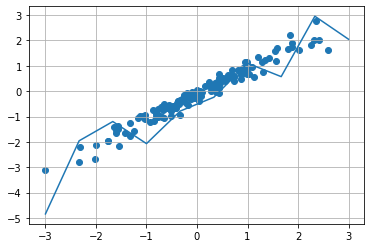

In [833]:
#pred_matrix = get_one_hot_pred_matrix(xs, kernel, prior)

plt.scatter(x_train,y_train)
plt.plot(x_plot,np.mean(pred_matrix, axis=0))
plt.fill_between(x_plot, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.5)
#for _ in range(20):
#    plt.plot(x_plot,model([xs,gids]))
plt.grid(True)

In [834]:
# x_plot = np.linspace(-3, 3, 10)
# xs1 = np.expand_dims(x_plot, 1).astype(np.float32)
# #xs1 = np.concatenate([xs1, np.tile(np.array([1,0,0]), 5).reshape((5,3))], axis=1)
# #xs1 = np.concatenate([xs1,np.zeros((len(xs1), 1)).astype(np.float32)], axis=1)
# gids1 = (np.zeros((10,))+0 ).astype(np.int32)
# pred_matrix1 = np.concatenate([model([xs1, gids1]) for _ in range(100)], axis=1).T

# xs2 = np.expand_dims(x_plot, 1).astype(np.float32)
# #xs2 = np.concatenate([xs2, np.tile(np.array([0,1,0]), 5).reshape((5,3))], axis=1)
# #xs2 = np.concatenate([xs2,np.zeros((len(xs2), 1)).astype(np.float32)], axis=1)
# gids2 = (np.zeros((10,))+1 ).astype(np.int32)
# pred_matrix2 = np.concatenate([model([xs2, gids2]) for _ in range(100)], axis=1).T

# xs3 = np.expand_dims(x_plot, 1).astype(np.float32)
# #xs3 = np.concatenate([xs3, np.tile(np.array([0,0,1]), 5).reshape((5,3))], axis=1)
# #xs3 = np.concatenate([xs3,np.zeros((len(xs3), 1)).astype(np.float32)], axis=1)
# gids3 = (np.zeros((10,))+2 ).astype(np.int32)
# pred_matrix3 = np.concatenate([model([xs3, gids3]) for _ in range(100)], axis=1).T

xsg = []
for i in range(num_groups):
    gids = (np.zeros((10,))+i ).astype(np.int32)
    xsg.append(np.concatenate([model([xs, gids]) for _ in range(100)], axis=1).T)

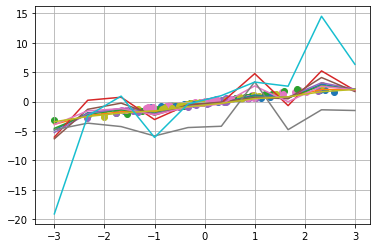

In [835]:
# plt.scatter(x1,y1)
# plt.scatter(x2,y2)
# plt.scatter(x3,y3)
#plt.scatter(x_test,y_test)

# plt.plot(np.linspace(-1, 1, 5),ys1)
# plt.plot(np.linspace(-1, 1, 5),ys2)
# plt.plot(np.linspace(-1, 1, 5),ys3)

for i in range(num_groups):
    plt.scatter(get_segments(x_train, gid_train, i), get_segments(y_train, gid_train, i))

    pred_matrix = xsg[i]
    plt.plot(x_plot,np.mean(pred_matrix, axis=0))
    plt.fill_between(x_plot, np.max(pred_matrix, axis=0),  np.min(pred_matrix, axis=0), alpha=0.2)
 
# plt.plot(x_plot,np.mean(pred_matrix2, axis=0))
# plt.fill_between(x_plot, np.max(pred_matrix2, axis=0),  np.min(pred_matrix2, axis=0), alpha=0.2)

# plt.plot(x_plot,np.mean(pred_matrix3, axis=0))
# plt.fill_between(x_plot, np.max(pred_matrix3, axis=0),  np.min(pred_matrix3, axis=0), alpha=0.2)
plt.grid(True)

In [792]:
tf.math.exp(4.)

<tf.Tensor: shape=(), dtype=float32, numpy=54.59815>

In [714]:
%tensorboard --logdir ../experiments/linear/tensorboard/ --host localhost

In [60]:
trainable_dist = tf.keras.Sequential([
            tfp.layers.VariableLayer(2 * 4*4),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t[..., :4*4],
                           scale=1e-5 + tf.nn.softplus(t[..., 4*4:])),
                reinterpreted_batch_ndims=1)),
        ])

In [66]:
trainable_dist(np.random.randn(4,10)).sample()

<tf.Tensor: id=267796, shape=(16,), dtype=float32, numpy=
array([ 2.231266  , -0.7096818 ,  0.3247058 ,  0.74108917, -0.1730364 ,
        1.0490683 ,  0.8167297 ,  0.3888446 , -1.002009  ,  0.45493028,
       -0.07120443, -0.2973723 , -0.38046578,  0.35281506, -0.5996742 ,
       -1.6448722 ], dtype=float32)>

# Radon

In [9]:
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')


def cache_or_download_file(cache_dir, url_base, filename):
    """Read a cached file or download it."""
    filepath = os.path.join(cache_dir, filename)
    if tf.io.gfile.exists(filepath):
        return filepath
    if not tf.io.gfile.exists(cache_dir):
        tf.io.gfile.makedirs(cache_dir)
    url = os.path.join(url_base, filename)
    print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
    urllib.request.urlretrieve(url, filepath)
    return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
    """Download the radon dataset and read as Pandas dataframe."""
    url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
    # Alternative source:
    # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
    #             'master/reference/data/')
    srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
    srrs2.rename(columns=str.strip, inplace=True)
    cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
    cty.rename(columns=str.strip, inplace=True)
    return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
    """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
    srrs2 = srrs2[srrs2.state==state].copy()
    cty = cty[cty.st==state].copy()
    
    # We will now join datasets on Federal Information Processing Standards
    # (FIPS) id, ie, codes that link geographic units, counties and county
    # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
    srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
    cty['fips'] = 1000 * cty.stfips + cty.ctfips
  
    df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
    df = df.drop_duplicates(subset='idnum')
    df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})
    
    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
    
    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
        pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
    county_name = map(str.strip, county_name)
    
    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
    df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
   
    return df, county_name

In [10]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())

In [17]:
# Save processed data. (So we can later read it in R.)
with open(os.path.join(CACHE_DIR, 'radon.csv'), 'w') as f:
    radon.to_csv(f, index=False)

In [19]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


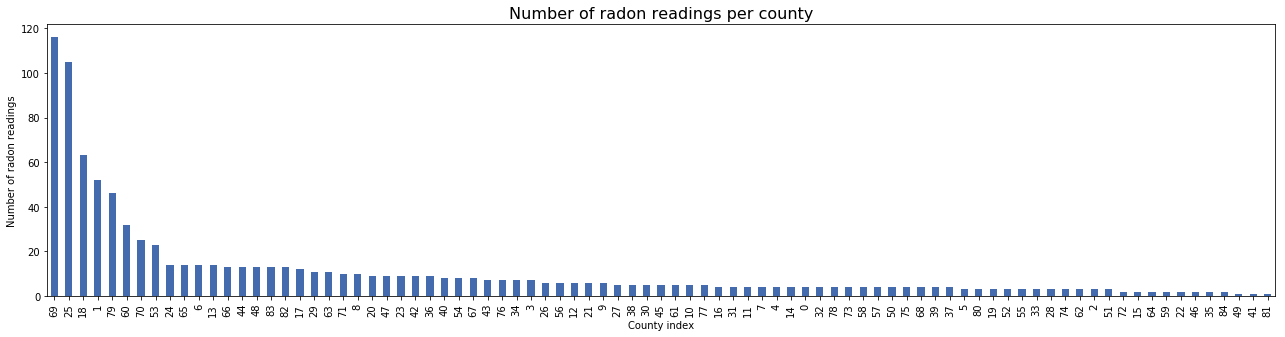

In [20]:

fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

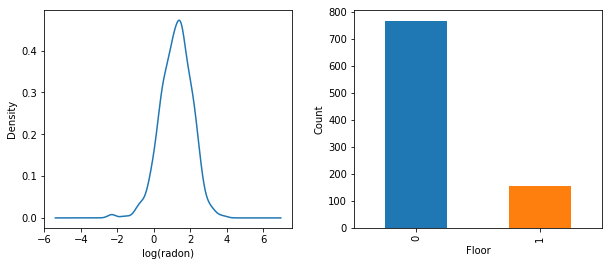

In [21]:

fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

In [22]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

In [35]:
def make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.Variable(initial_value=np.array(inv_scale_transform(1.), dtype=dtype))
    return tfp.distributions.Independent(
        tfp.distributions.Normal(
            loc=tf.zeros(num_counties, dtype=dtype),
            scale=fwd_scale_transform(raw_prior_scale)),
        reinterpreted_batch_ndims=1)


#make_weights_prior = tf.make_template(
#    name_='make_weights_prior', func_=_make_weights_prior)

In [45]:
def make_log_radon_likelihood(
    random_effect_weights, floor, county, log_county_uranium_ppm, init_log_radon_stddev):
    
    raw_likelihood_scale = tf.Variable(initial_value=np.array(
            inv_scale_transform(init_log_radon_stddev), dtype=dtype))
    fixed_effect_weights = tf.Variable(initial_value=np.array([0., 1.], dtype=dtype))
    fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
    random_effects = tf.cast(tf.gather(
        random_effect_weights * log_county_uranium_ppm,
        indices=tf.cast(county, tf.int32),
        axis=-1), tf.float32)
    linear_predictor = fixed_effects + random_effects
    return tfp.distributions.Normal(
        loc=linear_predictor, scale=fwd_scale_transform(raw_likelihood_scale))

In [55]:
def joint_log_prob(
    random_effect_weights, log_radon, floor, county, log_county_uranium_ppm, dtype):
    num_counties = len(log_county_uranium_ppm)
    rv_weights = make_weights_prior(num_counties, dtype)
    rv_radon = make_log_radon_likelihood(
        random_effect_weights,
        floor,
        county,
        log_county_uranium_ppm,
        init_log_radon_stddev=radon.log_radon.values.std())
    #print(random_effect_weights, log_radon)
    #print(rv_weights.log_prob(random_effect_weights)
    #        , tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))
    return (rv_weights.log_prob(random_effect_weights)
            + tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))

### Expectation Maximization

In [47]:

# Specify unnormalized posterior.

dtype = np.float32

log_county_uranium_ppm = radon[
    ['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
    return joint_log_prob(
        random_effect_weights=random_effect_weights,
        log_radon=dtype(radon.log_radon.values),
        floor=dtype(radon.floor.values),
        county=np.int32(radon.county.values),
        log_county_uranium_ppm=log_county_uranium_ppm,
        dtype=dtype)

In [56]:

# Set-up E-step.

step_size = tf.Variable(
    initial_value=np.array(0.2, dtype=dtype),
    trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=None),
    state_gradients_are_stopped=True)



/Users/milesturpin/miniconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:494: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [ ]:
# @tf.function
# def run_chain():
#     [
#         posterior_prob,
#         posterior_centers,
#         posterior_sds
#     ], kernel_results = tfp.mcmc.sample_chain(
#         num_results=number_of_steps,
#         num_burnin_steps=burnin,
#         current_state=initial_chain_state,
#         kernel=hmc)
#     return ([
#         posterior_prob,
#         posterior_centers,
#         posterior_sds
#     ], kernel_results)

#init_random_weights = tf.placeholder(dtype, shape=[len(log_county_uranium_ppm)])
init_random_weights = [tf.Variable(np.zeros(len(log_county_uranium_ppm)), dtype=dtype)]



@tf.function
def run_chain():
    posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
        num_results=3,
        num_burnin_steps=0,
        num_steps_between_results=0,
        current_state=init_random_weights,
        kernel=hmc)
    return posterior_random_weights, kernel_results


In [63]:
# Set-up M-step.

loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(1, name='global_step')

learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    #global_step=global_step,
    decay_steps=2,
    decay_rate=0.99)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, 
                              #global_step=global_step
                             )

TypeError: minimize() missing 1 required positional argument: 'var_list'

[<tf.Tensor: id=13, shape=(), dtype=float32, numpy=0.4>]

In [ ]:
maxiter = int(1500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
    [
        _,
        global_step_,
        loss_,
        posterior_random_weights_,
        kernel_results_,
        step_size_,
        prior_scale_,
        likelihood_scale_,
        fixed_effect_weights_,
    ] = sess.run([
        train_op,
        global_step,
        loss,
        posterior_random_weights,
        kernel_results,
        step_size,
        prior_scale,
        likelihood_scale,
        fixed_effect_weights,
    ], feed_dict={init_random_weights: w_})
    w_ = posterior_random_weights_[-1, :]
    num_accepted += kernel_results_.is_accepted.sum()
    num_drawn += kernel_results_.is_accepted.size
    acceptance_rate = num_accepted / num_drawn
    if i % 100 == 0 or i == maxiter - 1:
         print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
            'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
            'fixed_effect_weights:{}'.format(
                global_step_, loss_.mean(), acceptance_rate, step_size_,
                prior_scale_, likelihood_scale_, fixed_effect_weights_))

## One model

In [66]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


In [74]:
from sklearn.model_selection import train_test_split

x, y = radon[['floor', 'log_uranium_ppm']].values, radon['log_radon'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3, test_size=0.5)

In [75]:
tfd = tfp.distributions

negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf.keras.Sequential([
  #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

In [76]:
yhat = model(x_test)

In [77]:
yhat_mean = yhat.mean()

In [83]:
model.get_weights()

[array([[-0.67041105],
        [ 0.78343725]], dtype=float32), array([1.4535519], dtype=float32)]

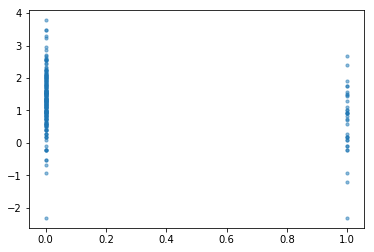

In [81]:
plt.scatter(x_test[:,0], y_test, s=10, alpha=0.5)
xs = np.linspace(0,1,4)
yhats = 
plt.plot()

## Variational Layer

In [84]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [64]:
def make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.Variable(initial_value=np.array(inv_scale_transform(1.), dtype=dtype))
    return tfp.distributions.Independent(
        tfp.distributions.Normal(
            loc=tf.zeros(num_counties, dtype=dtype),
            scale=fwd_scale_transform(raw_prior_scale)),
        reinterpreted_batch_ndims=1)

In [65]:
log_county_uranium_ppm

array([-0.6890476 , -0.84731287, -0.11345877, -0.5933525 , -0.14289048,
        0.3870567 ,  0.27161366,  0.2775787 , -0.33231547,  0.09586457,
       -0.6082198 ,  0.27368456, -0.7353201 ,  0.34378117, -0.05986042,
       -0.504996  ,  0.33956033, -0.6333907 , -0.02414516,  0.26385546,
        0.15571232,  0.29502505,  0.41491365,  0.22420698,  0.19661064,
       -0.09652081,  0.5035291 , -0.40059698, -0.75187224, -0.6633476 ,
        0.30902028, -0.05338601,  0.10973294, -0.00780337, -0.8818289 ,
        0.31102988, -0.6915964 , -0.6817089 ,  0.19444774,  0.44490373,
        0.3947344 ,  0.14960034,  0.01376483,  0.16586183,  0.1404226 ,
        0.02395087, -0.21005952, -0.09322665,  0.26093248,  0.39884993,
        0.24804688,  0.40545177,  0.26522171,  0.24315009, -0.20473038,
       -0.07402766, -0.16329217,  0.47860405,  0.26611108,  0.28114828,
       -0.4180535 ,  0.36632225,  0.38057798,  0.1931461 ,  0.52802485,
       -0.21204537,  0.06311563, -0.68343645,  0.23721212, -0.47

## Multilevel Model

In [10]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
    """`kernel_diag * x + bias` with broadcasting."""
    kernel_diag = tf.ones_like(x) * kernel_diag
    bias = tf.ones_like(x) * bias
    return x * kernel_diag + bias

$$y_i = \alpha_{j[i]}+ \beta x_i + \epsilon_i$$

In [448]:
x_tf = tf.convert_to_tensor(x_train)
y_tf = tf.convert_to_tensor(y_train)
gid_tf = tf.convert_to_tensor(gid_train)

In [11]:
def pooled_model(x):
    """Creates a joint distribution representing our generative process."""
    return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  # alpha
      tfd.Normal(loc=0., scale=1e5),  # beta
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(x, b1[..., tf.newaxis], b0[..., tf.newaxis]),
          scale_identity_multiplier=s)
  ])

@tf.function
def pooled_log_prob(alpha, beta, sigma):
    """Computes `joint_log_prob` pinned at `log_y`."""
    return pooled_model(x_tf).log_prob([alpha, beta, sigma, y_tf])

In [216]:
pooled_model(x_tf).sample()

[<tf.Tensor: shape=(), dtype=float32, numpy=-2712.4773>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-41684.473>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.37340498>,
 <tf.Tensor: shape=(22,), dtype=float32, numpy=
 array([-16165.783, -59387.27 ,  25443.238, -62480.027,  18007.951,
         19541.203,  15089.764,  23936.227, -27815.273,  26601.693,
         23246.678, -11497.546, -86516.52 ,  37619.34 ,  57801.59 ,
         11565.435, -37231.625, -69918.98 ,  34342.32 , -29740.967,
         -9099.353,  15083.45 ], dtype=float32)>]

In [218]:
pooled_log_prob(tf.ones((10,)), tf.ones((10,)), tf.ones((10,)))

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-119.833786, -119.833786, -119.833786, -119.833786, -119.833786,
       -119.833786, -119.833786, -119.833786, -119.833786, -119.833786],
      dtype=float32)>

In [219]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
    """Samples from the pooled model."""
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=pooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.005)

    initial_state = [
      tf.zeros([num_chains], name='init_alpha'),
      tf.zeros([num_chains], name='init_beta'),
      tf.ones([num_chains], name='init_sigma')
    ]

    # Contrain `sigma` to the positive real axis. Other variables are
    # unconstrained.
    unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

    samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

    acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

    return samples, acceptance_probs

In [14]:
import collections
tfb = tfp.bijectors

In [221]:
PooledModel = collections.namedtuple('PooledModel', ['alpha', 'beta', 'sigma'])

In [222]:
samples, acceptance_probs = sample_pooled(
    num_chains=tf.convert_to_tensor(4),
    num_results=tf.convert_to_tensor(1000),
    num_burnin_steps=tf.convert_to_tensor(1000),
    num_observations=tf.convert_to_tensor(len(x_tf)))

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance Probabilities for each chain:  [1. 1. 1. 1.]


In [223]:
for var, var_samples in pooled_samples._asdict().items():
    print('R-hat for ', var, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  alpha :	 1.1902891
R-hat for  beta :	 1.0572693
R-hat for  sigma :	 1.0473523


In [53]:
def reduce_samples(var_samples, reduce_fn):
    """Reduces across leading two dims using reduce_fn. """
    # Collapse the first two dimensions, typically (num_chains, num_samples), and
    # compute np.mean or np.std along the remaining axis.
    if isinstance(var_samples, tf.Tensor):
        var_samples = var_samples.numpy() # convert to numpy array
    var_samples = np.reshape(var_samples, (-1,) +  var_samples.shape[2:])
    return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)

sample_mean = lambda samples : reduce_samples(samples, np.mean)
sample_var = lambda samples : reduce_samples(samples, np.var)

In [54]:
LinearEstimates = collections.namedtuple('LinearEstimates',
                                        ['intercept', 'slope'])

pooled_estimate = LinearEstimates(
  intercept=sample_mean(pooled_samples.alpha),
  slope=sample_mean(pooled_samples.beta)
)

plt.scatter(x_tf, y_tf)
xvals = np.linspace(-3.2, 3.2)
plt.ylabel('Radon level (Log Scale)')
plt.xticks([0, 1], ['Basement', 'First Floor'])
plt.plot(xvals, pooled_estimate.intercept + pooled_estimate.slope * xvals, 'r--')
plt.show()

NameError: name 'pooled_samples' is not defined

In [55]:
def plot_traces(var_name, samples, num_chains):
    if isinstance(samples, tf.Tensor):
        samples = samples.numpy() # convert to numpy array
    fig, axes = plt.subplots(1, 3, figsize=(14, 1.5), sharex='col', sharey='col')
    for chain in range(num_chains):
        axes[0].plot(samples[:, chain], alpha=0.7)
        axes[1].plot(pd.Series(samples[:, chain]).expanding().mean().values)
        sns.kdeplot(samples[:, chain], ax=axes[2], shade=False)
        axes[0].title.set_text("'{}' trace".format(var_name))
        axes[2].title.set_text("'{}' distribution".format(var_name))
        
        axes[0].set_xlabel('Iteration')
        axes[2].set_xlabel(var_name)
    plt.show()

In [15]:
import seaborn as sns

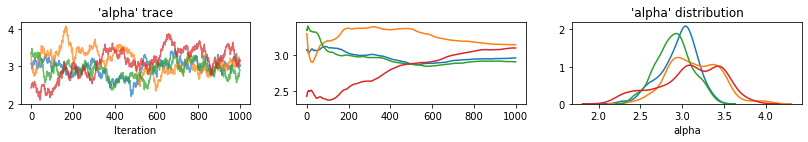

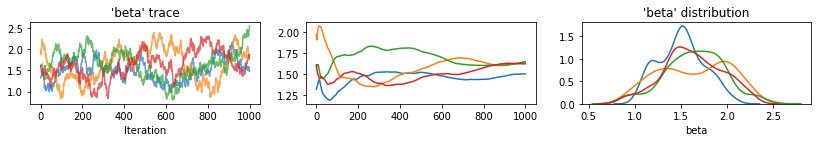

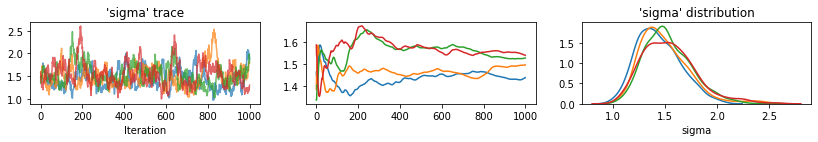

In [235]:
for var, var_samples in pooled_samples._asdict().items():
    plot_traces(var, samples=var_samples, num_chains=4)

## Actual multilevel model now (MCMC)

In [53]:
def reduce_samples(var_samples, reduce_fn):
    """Reduces across leading two dims using reduce_fn. """
    # Collapse the first two dimensions, typically (num_chains, num_samples), and
    # compute np.mean or np.std along the remaining axis.
    if isinstance(var_samples, tf.Tensor):
        var_samples = var_samples.numpy() # convert to numpy array
    var_samples = np.reshape(var_samples, (-1,) +  var_samples.shape[2:])
    return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)

sample_mean = lambda samples : reduce_samples(samples, np.mean)
sample_var = lambda samples : reduce_samples(samples, np.var)

In [10]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
    """`kernel_diag * x + bias` with broadcasting."""
    kernel_diag = tf.ones_like(x) * kernel_diag
    bias = tf.ones_like(x) * bias
    return x * kernel_diag + bias

$$y_i = \alpha_{j[i]}+ \beta x_i + \epsilon_i$$

In [458]:
x_tf = tf.cast(tf.convert_to_tensor(x_train), tf.float32)
y_tf = tf.cast(tf.convert_to_tensor(y_train), tf.float32)
gid_tf = tf.cast(tf.convert_to_tensor(gid_train), tf.int32)

In [14]:
import collections
tfb = tfp.bijectors

In [54]:
LinearEstimates = collections.namedtuple('LinearEstimates',
                                        ['intercept', 'slope'])

NameError: name 'pooled_samples' is not defined

In [464]:
num_groups = tf.cast(tf.convert_to_tensor(max(gid_tf)+1), tf.int32)

In [241]:
# def varying_intercepts_and_slopes_model(x_tf, gid_tf):
#     """Creates a joint distribution for the varying slope model."""
#     return tfd.JointDistributionSequential([
#       tfd.Normal(loc=0., scale=1e5),    # mu_a
      
#       tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
#       tfd.Normal(loc=0., scale=1e5),    # mu_b
#       tfd.HalfCauchy(loc=0., scale=5),  # sigma_b
#       # sigma_b, mu_b unused
#       lambda sigma_b, mu_b, sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
#           loc=affine(tf.ones([num_groups]), mu_a[..., tf.newaxis]),
#           scale_diag=sigma_a[..., tf.newaxis]),
#       # a unused
#       lambda a, sigma_b, mu_b: tfd.MultivariateNormalDiag(  # b
#           loc=affine(tf.ones([num_groups]), mu_b[..., tf.newaxis]),
#           scale_identity_multiplier=sigma_b),
#       tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
#       lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
#           loc=affine(x_tf, tf.gather(b, gid_tf, axis=-1),
#                      tf.gather(a, gid_tf, axis=-1)),
#           scale_identity_multiplier=sigma_y)
#   ])


# @tf.function
# def varying_intercepts_and_slopes_log_prob(mu_a, sigma_a, mu_b, sigma_b, a, b,
#                                            sigma_y):
#     """Computes joint log prob pinned at `log_radon`."""
#     return varying_intercepts_and_slopes_model(x_tf, gid_tf).log_prob(
#       [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y, y_tf])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.22187409, -6.5326824 ,  1.0164808 ], dtype=float32)>

In [38]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
    """`kernel_diag * x + bias` with broadcasting."""
    kernel_diag = tf.ones_like(x) * kernel_diag
    bias = tf.ones_like(x) * bias
    return x * kernel_diag + bias

In [21]:
joint_model.sample(2)

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.2721875, -2.1811929], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[ 0.06765052, 44.936863  ,  2.3815026 ],
        [ 0.81975776,  2.8766563 ,  2.2258732 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[ 1.1994227 , -9.511776  , -4.505435  ],
        [-2.4436374 , -0.76713336, -2.6251135 ]], dtype=float32)>]

In [23]:
joint_model.log_prob(joint_model.sample(4))

InvalidArgumentError: Incompatible shapes: [4] vs. [4,3] [Op:AddV2]

In [37]:
prob_model.log_prob(prob_model.sample(3))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-56.696854, -56.466652, -64.17481 ], dtype=float32)>

In [465]:
def varying_intercepts_and_slopes_model(x_tf, gid_tf):
    """Creates a joint distribution for the varying slope model."""
    return tfd.JointDistributionSequential([
        tfd.Normal(loc=0., scale=1e5, name='w_z_0'),          # z_0 ~ N(0, v^-1=1e5)
       
        
        tfd.Independent(
            tfd.HalfCauchy(loc=tf.zeros([num_groups]), scale=5., name='w_lambda_k'),
            reinterpreted_batch_ndims=1),

        lambda w_lambda_k, w_z_0: tfd.MultivariateNormalDiag( # z_k ~ MVN(z_0, lambda_k)
            loc=w_z_0[...,tf.newaxis],
            scale_diag=w_lambda_k,
            name='w_z_k'),

        tfd.Normal(loc=0., scale=1e5, name='b_z_0'),          # z_0 ~ N(0, v^-1=1e5)
        tfd.Independent(tfd.HalfCauchy(loc=tf.zeros([num_groups]), scale=5., name='b_lambda_k'), reinterpreted_batch_ndims=1),
        
        lambda b_lambda_k, b_z_0: tfd.MultivariateNormalDiag( # z_k ~ MVN(z_0, lambda_k)
            loc=b_z_0[...,tf.newaxis],
            scale_diag=b_lambda_k,
            name='b_z_k'),

        
        tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
        
        # b_lambda_k, b_z_0 are unused
        lambda sigma_y, b_z_k, b_lambda_k, b_z_0, w_z_k: tfd.MultivariateNormalDiag(  # y
            loc=affine(x_tf, tf.gather(w_z_k, gid_tf, axis=-1),
                       tf.gather(b_z_k, gid_tf, axis=-1)),
            scale_identity_multiplier=sigma_y,
            name='y')
   ])

# mu_a = b_z_0
# sigma_a = lambda_k
# a = b_z_k


# @tf.function
# def varying_intercepts_and_slopes_log_prob(mu_a, sigma_a, mu_b, sigma_b, a, b,
#                                            sigma_y):
#     """Computes joint log prob pinned at `log_radon`."""
#     return varying_intercepts_and_slopes_model(x_tf, gid_tf).log_prob(
#       [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y, y_tf])
@tf.function
def varying_intercepts_and_slopes_log_prob(w_z_0, w_lambda_k, w_z_k, b_z_0, b_lambda_k, b_z_k,
                                           sigma_y):
    """Computes joint log prob pinned at `log_radon`."""
    return varying_intercepts_and_slopes_model(x_tf, gid_tf).log_prob(
      [w_z_0, w_lambda_k, w_z_k, b_z_0, b_lambda_k, b_z_k, sigma_y, y_tf])

In [466]:
prob_model = varying_intercepts_and_slopes_model(x_tf, gid_tf)

In [467]:
prob_model.sample(2)

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-199471.22,  -65712.55], dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[4.9787621e+00, 7.5661860e+00, 7.8822794e+00, 9.8510437e+00,
         1.4121916e+01, 1.5583464e+02, 5.3411918e+00, 3.1768854e+01,
         1.4972672e+00, 1.8050024e+01],
        [6.1001563e+00, 1.6061880e+01, 1.3481597e+01, 1.4475650e-01,
         2.4103659e-01, 3.2787321e+00, 7.0571618e+00, 3.6470491e-01,
         2.0183978e+00, 7.5035954e+00]], dtype=float32)>,
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[-199476.6  , -199477.45 , -199468.56 , -199465.83 , -199461.1  ,
         -199429.83 , -199472.62 , -199470.61 , -199472.48 , -199462.98 ],
        [ -65714.35 ,  -65739.9  ,  -65685.76 ,  -65712.67 ,  -65712.8  ,
          -65716.82 ,  -65702.27 ,  -65712.78 ,  -65713.19 ,  -65705.945]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-59422.56, -70658.2 ], dtype=float32)>,
 <tf.Tensor: sh

In [378]:
[x.numpy().tolist() for x in varying_intercepts_and_slopes_model(x_tf, gid_tf).sample(2)]

[[-104514.25, 110465.546875],
 [[18.772817611694336, 0.30942702293395996, 0.9124424457550049],
  [9.114513397216797, 7.571076393127441, 7.833651542663574]],
 [[-104486.4765625, -104514.2890625, -104514.71875],
  [110468.9375, 110462.375, 110471.125]],
 [-181242.984375, -35604.99609375],
 [[13.035266876220703, 1.3609386682510376, 0.02157735824584961],
  [6.598439693450928, 6.7481279373168945, 15.439958572387695]],
 [[-181242.625, -181243.28125, -181242.984375],
  [-35604.203125, -35611.859375, -35593.22265625]],
 [3.8229777812957764, 1.4269061088562012],
 [[-214978.84375,
   -323340.8125,
   -110649.9765625,
   -331096.15625,
   -129290.8828125,
   -125458.0,
   -136607.5625,
   -114440.296875,
   -244184.40625,
   -107766.4765625,
   -116150.34375,
   -203270.140625,
   -391306.75,
   -80122.9453125,
   -29560.08984375,
   -145461.8125,
   -267795.625,
   -349702.28125,
   -88358.0625,
   -248985.84375,
   -197248.796875,
   -136621.734375],
  [61.90617370605469,
   114572.84375,
   -1

In [385]:
varying_intercepts_and_slopes_log_prob(
    [-12.796854  ,  -0.77070504],
 
    [[0.49399886, 9.038777  , 0.33977315],
        [3.41045   , 0.03022287, 0.40633935]],

    [[-12.530298  ,  -8.653396  , -12.318998  ],
        [ 7.7513633 ,  0.77435315,  1.3323231 ]],

    [18.831003 ,  7.8118763],

    [[6.2050328e-02, 2.9020339e-01, 8.1278968e-01],
        [6.2063926e-01, 5.7410507e-04, 3.5293171e-01]],
    
    [[18.747215 , 18.60444  , 20.00206  ],
        [ 7.675845 ,  7.8126297,  7.80311  ]],

    [0.00140884, 0.22555475], 
         )

TypeError: in user code:


    TypeError: tf__varying_intercepts_and_slopes_log_prob() missing 6 required positional arguments: 'w_lambda_k', 'w_z_k', 'b_z_0', 'b_lambda_k', 'b_z_k', and 'sigma_y'


In [389]:
varying_intercepts_and_slopes_model(x_tf, gid_tf).log_prob([[86806.796875, 57500.81640625],
 [[20.046422958374023, 0.22496256232261658, 11.801937103271484],
  [8.82828140258789, 10.479497909545898, 1.3312065601348877]],
 [[86826.1796875, 86806.5078125, 86808.578125],
  [57523.60546875, 57482.7109375, 57501.625]],
 [183214.96875, 229708.453125],
 [[7.258034706115723, 3.2598986625671387, 10.279364585876465],
  [2.394866704940796, 4.967094421386719, 3.9314305782318115]],
 [[183207.25, 183217.625, 183188.953125],
  [229706.703125, 229712.296875, 229705.015625]],
 [8.92887020111084, 2.1780433654785156],
 [[211205.046875,
   301235.5,
   124572.3671875,
   307694.1875,
   140025.625,
   136839.640625,
   146138.296875,
   127695.453125,
   235471.0625,
   122123.7421875,
   129152.1484375,
   201502.78125,
   357756.0625,
   99198.4140625,
   57161.74609375,
   153470.96875,
   255073.640625,
   323187.09375,
   106010.984375,
   239508.5625,
   196519.328125,
   146152.9375],
  [248262.9375,
   307865.71875,
   190885.15625,
   312135.78125,
   201123.28125,
   199000.046875,
   205164.140625,
   192931.96875,
   264336.1875,
   189255.078125,
   193917.4375,
   241826.296875,
   345356.96875,
   174069.0625,
   146198.390625,
   210006.421875,
   277322.0,
   322452.90625,
   178572.640625,
   267002.90625,
   238520.40625,
   205172.171875]]])

InvalidArgumentError: Incompatible shapes: [2] vs. [2,3] [Op:AddV2]

In [329]:
x_tf

<tf.Tensor: shape=(22,), dtype=float32, numpy=
array([ 0.32274258,  1.3596085 , -0.67545575,  1.4338182 , -0.49708647,
       -0.53386486, -0.42707244, -0.63928974,  0.6022096 , -0.7032401 ,
       -0.62276155,  0.21074116,  2.0104349 , -0.96755266, -1.4517193 ,
       -0.34251967,  0.8281072 ,  1.6122612 , -0.8889478 ,  0.64840233,
        0.15321667, -0.4269241 ], dtype=float32)>

In [338]:
gid_tf

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([2, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1],
      dtype=int32)>

In [468]:
@tf.function
def sample_varying_intercepts_and_slopes(num_chains, num_results,
                                         num_burnin_steps):
    """Samples from the varying intercepts and slopes model."""
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_intercepts_and_slopes_log_prob,
      num_leapfrog_steps=50,
      step_size=0.01)

#     initial_state = [
#       tf.zeros([num_chains], name='init_mu_a'),
#       tf.ones([num_chains], name='init_sigma_a'),
#       tf.zeros([num_chains], name='init_mu_b'),
#       tf.ones([num_chains], name='init_sigma_b'),
#       tf.zeros([num_chains, num_groups], name='init_a'),
#       tf.zeros([num_chains, num_groups], name='init_b'),
#       tf.ones([num_chains], name='init_sigma_y')
#     ]
    initial_state = [
        tf.zeros([num_chains], name='init_w_z_0'),
        tf.ones([num_chains, num_groups], name='init_w_lambda_k'),
        tf.zeros([num_chains, num_groups], name='init_w_z_k'),
        tf.zeros([num_chains], name='init_b_z_0'),
        tf.ones([num_chains, num_groups], name='init_b_lambda_k'),
        tf.zeros([num_chains, num_groups], name='init_b_z_k'),
        tf.ones([num_chains], name='init_sigma_y')
    ]
    unconstraining_bijectors = [
        tfb.Identity(),  # w_z_0
        tfb.Exp(),    #  w_lambda_k
        tfb.Identity(),  # w_z_k
        tfb.Identity(),  # b_z_0
        tfb.Exp(),    # b_lambda_k
        tfb.Identity(),  # b_z_k
        tfb.Exp()        # sigma_y
    ]
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
    #kernel = hmc
    
    samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

    acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

    return samples, acceptance_probs

In [469]:
VaryingInterceptsAndSlopesModel = collections.namedtuple(
    'VaryingInterceptsAndSlopesModel',
    ['w_z_0', 'w_lambda_k', 'w_z_k', 'b_z_0', 'b_lambda_k', 'b_z_k', 'sigma_y'])

samples, acceptance_probs = sample_varying_intercepts_and_slopes(
    num_chains=tf.convert_to_tensor(4), 
    num_results=tf.convert_to_tensor(2000), 
    num_burnin_steps=tf.convert_to_tensor(500))

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_intercepts_and_slopes_samples = VaryingInterceptsAndSlopesModel._make(
    samples)

/Users/milesturpin/miniconda3/envs/latent2/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance Probabilities:  [0.98   0.983  0.985  0.9825]


In [470]:
for var in ['w_z_0', 'w_lambda_k', 'w_z_k', 'b_z_0', 'b_lambda_k', 'b_z_k',]:
    print(
      'R-hat for ', var, '\t: ',
      tfp.mcmc.potential_scale_reduction(
          getattr(varying_intercepts_and_slopes_samples, var)).numpy())

R-hat for  w_z_0 	:  1.0166626
R-hat for  w_lambda_k 	:  [1.0009257 1.011139  1.0044041 1.0073086 1.0032026 1.0057665 1.0046812
 1.0266851 1.0043405 1.0093606]
R-hat for  w_z_k 	:  [1.002093  1.0015132 1.0085849 1.0014577 1.0005448 1.0012786 1.004011
 1.0004046 1.0030167 1.0021143]
R-hat for  b_z_0 	:  1.013389
R-hat for  b_lambda_k 	:  [1.0090065 1.0086062 1.0071253 1.0020653 1.0136294 1.0049367 1.0090318
 1.004395  1.011388  1.0086077]
R-hat for  b_z_k 	:  [1.0006999 1.0010908 1.0041853 1.0033852 1.0023205 1.0049114 1.0146133
 1.0020427 1.0007039 1.0026224]


In [474]:
def plot_intercepts_and_slopes(linear_estimates, title):
    
    fig, axes = plt.subplots(1,2, figsize=(15,7))
    
    for i in range(num_groups):
        plt.scatter(get_segments(x_train, gid_train, i), get_segments(y_train, gid_train, i))

#     plt.plot(xs,ys1)
#     plt.plot(xs,ys2)
#     plt.plot(xs,ys3)
    
    xvals = np.linspace(-3, 3)
    intercepts = np.ones([num_groups]) * linear_estimates.intercept
    slopes = np.ones([num_groups]) * linear_estimates.slope
    
    for c in range(num_groups):
        ax.plot(xvals, intercepts[c] + slopes[c] * xvals)
    #plt.xlim(-0.2, 1.2)
    #ax.set_xticks([0, 1])
    #ax.set_xticklabels(['Basement', 'First Floor'])
    #ax.set_ylabel('Log Radon level')
    plt.title(title)
    plt.grid()
    plt.show()

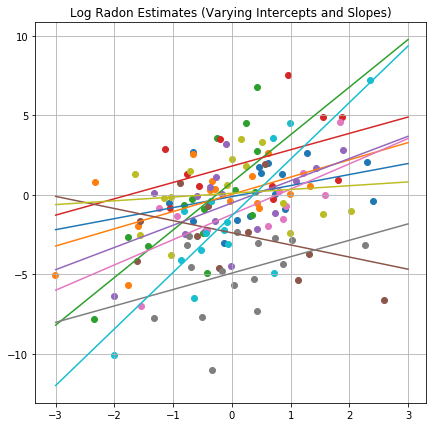

In [475]:
varying_intercepts_and_slopes_estimates = LinearEstimates(
    # NOTE THAT I HAD TO SWITCH B AND W HERE!!!
    sample_mean(varying_intercepts_and_slopes_samples.b_z_k),
    sample_mean(varying_intercepts_and_slopes_samples.w_z_k))

plot_intercepts_and_slopes(
    varying_intercepts_and_slopes_estimates,
    'Log Radon Estimates (Varying Intercepts and Slopes)')

In [59]:
varying_intercepts_and_slopes_estimates
get_model = lambda est: lambda x: (
    varying_intercepts_and_slopes_estimates.intercept[est] 
    + varying_intercepts_and_slopes_estimates.slope[est] * x)
model0 = get_model(0)
model1 = get_model(1)
model2 = get_model(2)

In [476]:
def get_params():
    for i in range(num_groups):
        print(f'Intercept:{round(varying_intercepts_and_slopes_estimates.intercept[i], 2)}')
        print(f'Slope:{round(varying_intercepts_and_slopes_estimates.slope[i], 2)}')

def get_metrics(x, y, gid):
    for i in range(num_groups):
        model = get_model(i)
        xi = get_segments(x, gid, i)
        yi = get_segments(y, gid, i)
        
        print('MSE', round(mean_squared_error(yi, model(xi)), 3))
        print('R2', round(r2_score(yi, model(xi)), 3))
        
get_params()
print('TRAIN')
get_metrics(x_train, y_train, gid_train)
print('TEST')
get_metrics(x_test, y_test, gid_test)

Intercept:-0.12999999523162842
Slope:0.6899999976158142
Intercept:0.019999999552965164
Slope:1.0800000429153442
Intercept:0.7699999809265137
Slope:2.990000009536743
Intercept:1.7899999618530273
Slope:1.0299999713897705
Intercept:-0.5299999713897705
Slope:1.399999976158142
Intercept:-2.4000000953674316
Slope:-0.7599999904632568
Intercept:-1.2400000095367432
Slope:1.590000033378601
Intercept:-4.940000057220459
Slope:1.0299999713897705
Intercept:0.09000000357627869
Slope:0.23999999463558197
Intercept:-1.3300000429153442
Slope:3.559999942779541
TRAIN
MSE 2.734
R2 0.089
MSE 3.407
R2 0.342
MSE 5.549
R2 0.549
MSE 5.157
R2 0.166
MSE 4.113
R2 0.327
MSE 5.077
R2 0.179
MSE 3.259
R2 0.537
MSE 4.916
R2 0.133
MSE 4.382
R2 -0.008
MSE 5.618
R2 0.701
TEST
MSE 8.677
R2 -0.424
MSE 5.354
R2 0.127
MSE 9.616
R2 0.117
MSE 6.467
R2 0.059
MSE 7.195
R2 -0.245
MSE 7.842
R2 -0.242
MSE 6.058
R2 0.363
MSE 5.793
R2 -0.007
MSE 11.146
R2 -0.045
MSE 5.602
R2 0.66


MSE 1.132
R2 0.566
1.766 3.545
MSE 1.04
R2 0.211
0.345 2.622
MSE 0.813
R2 0.811
2.927 4.198

In [477]:
def plot_traces(var_name, samples, num_chains):
    if isinstance(samples, tf.Tensor):
        samples = samples.numpy() # convert to numpy array
    fig, axes = plt.subplots(1, 3, figsize=(14, 1.5), sharex='col', sharey='col')
    for chain in range(num_chains):
        if len(samples[:,chain].shape) > 1:
            for group in range(num_groups):
                axes[0].plot(samples[:, chain, group], alpha=0.7)
                axes[1].plot(pd.Series(samples[:, chain, group]).expanding().mean().values)
                sns.kdeplot(samples[:, chain, group], ax=axes[2], shade=False)
                axes[0].title.set_text("'{}' trace".format(var_name))
                axes[2].title.set_text("'{}' distribution".format(var_name))

                axes[0].set_xlabel('Iteration')
                axes[2].set_xlabel(var_name)
        else:
            axes[0].plot(samples[:, chain], alpha=0.7)
            axes[1].plot(pd.Series(samples[:, chain]).expanding().mean().values)
            sns.kdeplot(samples[:, chain], ax=axes[2], shade=False)
            axes[0].title.set_text("'{}' trace".format(var_name))
            axes[2].title.set_text("'{}' distribution".format(var_name))

            axes[0].set_xlabel('Iteration')
            axes[2].set_xlabel(var_name)
    plt.show()

In [478]:
for att in ['w_z_0', 'w_lambda_k', 'w_z_k', 'b_z_0', 'b_lambda_k', 'b_z_k']:
    print(att, 
          sample_mean(getattr(varying_intercepts_and_slopes_samples, att)[-500:]),
         sample_var(getattr(varying_intercepts_and_slopes_samples, att)[-500:]))

w_z_0 1.1198647 0.3367741
w_lambda_k [3.2158225 2.9454932 4.612305  3.0556357 3.6773005 4.468268  2.6949959
 3.235308  4.037399  5.615958 ] [24.64855  21.647514 19.170946 20.245058 36.909485 18.702175 18.50441
 32.038124 56.17314  80.499756]
w_z_k [ 0.6964812   1.131363    2.9843593   1.034363    1.4423571  -0.7426778
  1.5839553   1.0359681   0.23806268  3.5382128 ] [0.3168988  0.20812769 0.48113525 0.3214314  0.3113349  0.35189238
 0.31724045 0.36185074 0.3014702  0.3968215 ]
b_z_0 -0.31157202 0.566031
b_lambda_k [3.032131  2.4839947 3.1214406 4.789245  2.6719272 5.259704  3.8753974
 8.232292  2.909787  4.4421515] [14.504512 10.038731 14.361613 25.611372 13.78433  65.44339  21.18501
 92.54015  14.674362 75.35584 ]
b_z_k [-0.11337665  0.03371571  0.7506799   1.7611878  -0.49078208 -2.3336532
 -1.2693521  -4.9451995   0.05627395 -1.3567038 ] [0.38080394 0.34324434 0.41256857 0.53751355 0.31223372 0.53439516
 0.51083136 0.34066945 0.2952229  0.34732667]


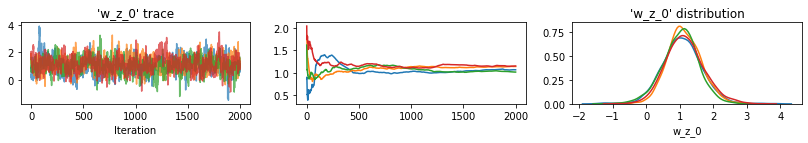

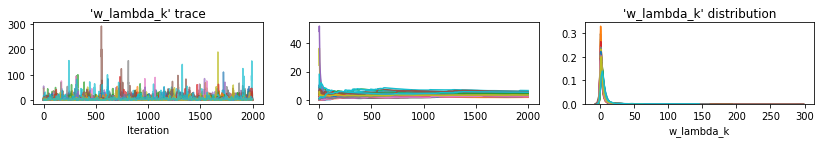

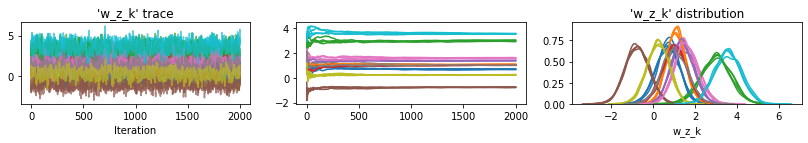

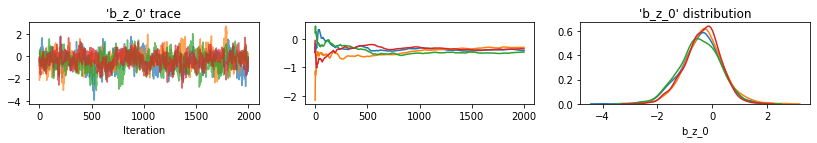

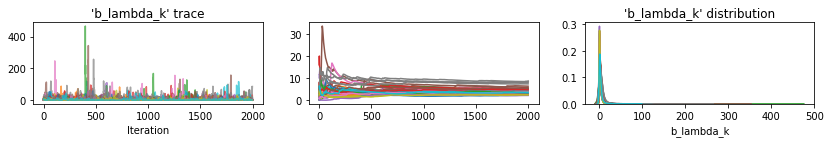

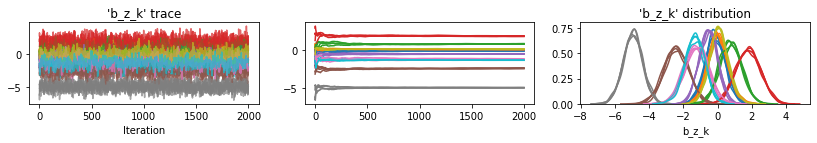

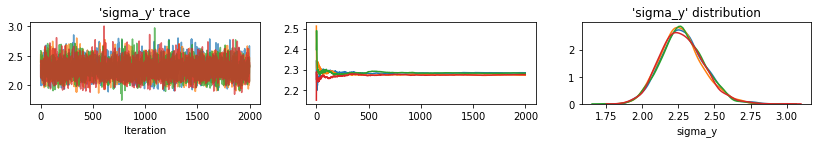

In [479]:
for var, var_samples in varying_intercepts_and_slopes_samples._asdict().items():
    plot_traces(var, samples=var_samples, num_chains=4)